In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
import numpy as np

from sklearn.linear_model import LogisticRegression as LR
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.svm import SVC
from xgboost import XGBClassifier as XGB

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import ConfusionMatrixDisplay, f1_score, accuracy_score, recall_score, precision_score

import matplotlib.pyplot as plt

from modeling_hyperparameters import model_training_param_space
from helper import get_results

import time

In [2]:
def models_results(y_test, models, models_names):
    f1 = []
    accuracy = []
    precision = []
    recall = []
    #Run thorugh each of the models to get their performance metrics
    for test_preds in models:
        f1.append(f1_score(y_test, test_preds))
        accuracy.append(accuracy_score(y_test, test_preds))
        precision.append(precision_score(y_test, test_preds))
        recall.append(recall_score(y_test, test_preds))
    #store results in dataframe
    results = pd.DataFrame([f1, accuracy, precision,recall],
                      index= ['f1','accuracy','precision','recall'],
                           columns=[models_names])
    #Change orientation of the dataframe
    return results.transpose()

In [3]:
df_train = pd.read_csv('data/df_train.csv', index_col=[0])
df_val = pd.read_csv('data/df_val.csv', index_col=[0])

In [4]:
selected_features = ['soundex', 'jaccard_2', 'overlap_2', 'bag', 'levenshtein', 'dlevenshtein', 'jaro_winkler',\
                       'smith_waterman', 'editex', 'lcsseq', 'bz2ncd']

### Simple models with default settings

In [10]:
lr = LR(random_state=42)
lr.fit(df_train[selected_features], df_train['label'])
lr_predict = lr.predict(df_val[selected_features])

dtc = DTC(random_state=42)
dtc.fit(df_train[selected_features], df_train['label'])
dtc_predict = dtc.predict(df_val[selected_features])

rfc = RFC(random_state=42)
rfc.fit(df_train[selected_features], df_train['label'])
rfc_predict = rfc.predict(df_val[selected_features])

svc = SVC(random_state=42)
svc.fit(df_train[selected_features], df_train['label'])
svc_predict = svc.predict(df_val[selected_features])

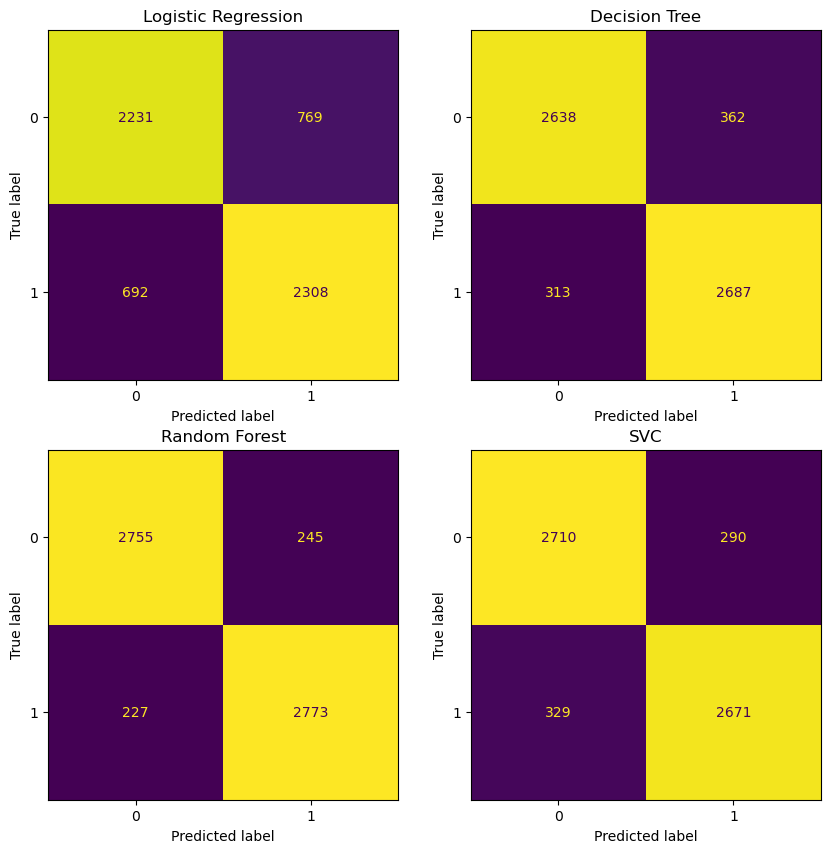

In [11]:
plt.figure(figsize=(10,10))
ax1 = plt.subplot(2,2,1)
ConfusionMatrixDisplay.from_predictions(df_val['label'], lr_predict, colorbar=False, ax=ax1)
ax1.set_title('Logistic Regression')

ax2 = plt.subplot(2,2,2)
ConfusionMatrixDisplay.from_predictions(df_val['label'], dtc_predict, colorbar=False, ax=ax2)
ax2.set_title('Decision Tree')

ax3 = plt.subplot(2,2,3)
ConfusionMatrixDisplay.from_predictions(df_val['label'], rfc_predict, colorbar=False, ax=ax3)
ax3.set_title('Random Forest')

ax4 = plt.subplot(2,2,4)
ConfusionMatrixDisplay.from_predictions(df_val['label'], svc_predict, colorbar=False, ax=ax4)
ax4.set_title('SVC')
plt.show()

In [12]:
models_results(df_val['label'], [lr_predict, dtc_predict, rfc_predict, svc_predict], ['LR', 'DTC', 'RFC', 'SVC'])

,f1,accuracy,precision,recall
LR,0.759585,0.756500,0.750081,0.769333
DTC,0.888411,0.887500,0.881273,0.895667
RFC,0.921569,0.921333,0.918820,0.924333
SVC,0.896158,0.896833,0.902060,0.890333


In [13]:
lr_predict = lr.predict(df_train[selected_features])
dtc_predict = dtc.predict(df_train[selected_features])
rfc_predict = rfc.predict(df_train[selected_features])
svc_predict = svc.predict(df_train[selected_features])

In [14]:
models_results(df_train['label'], [lr_predict, dtc_predict, rfc_predict, svc_predict], ['LR', 'DTC', 'RFC', 'SVC'])

,f1,accuracy,precision,recall
LR,0.748481,0.74535,0.739389,0.7578
DTC,0.999099,0.99910,0.999700,0.9985
RFC,0.999100,0.99910,0.998601,0.9996
SVC,0.901617,0.90235,0.908436,0.8949


### Hyperparameter tuning

In [11]:
def model_hyperparameter_tuning(
    X_train,
    y_train,
    X_val,
    y_val,
    model_name: str,
    model,
    search_space: dict,
    max_iter: int,
):
    train_size = X_train.shape[0]
    num_features = X_train.shape[1]
    X = pd.concat([X_train, X_val], ignore_index=True)
    y = pd.concat([y_train, y_val], ignore_index=True)
    clf = RandomizedSearchCV(
        estimator=model,
        param_distributions=search_space,
        n_iter=max_iter,
        scoring=["f1", "recall", "precision", "average_precision"],
        refit="average_precision",
        cv=[(X.index[:train_size], X.index[train_size:])],
        random_state=42,
        return_train_score=True,
        n_jobs=-1,
    )
    clf = clf.fit(X, y)
    cv_results = clf.cv_results_
    hyperparams_list = cv_results["params"]
    metrics = {
        key.removeprefix('split0_'): val
        for key, val in cv_results.items()
        if (
            key.startswith("split") and key.endswith(("f1", "precision", "recall", "average_precision"))
        )
    }
    metrics_list = [dict(zip(metrics, vals)) for vals in zip(*metrics.values())]
    return hyperparams_list, metrics_list

In [12]:
MAX_EVALS_RANDOM = 100
df_results = pd.DataFrame({})
for model_name, (model, search_space) in model_training_param_space.items():
    start = time.time()
    hyperparams_list, metrics_list = model_hyperparameter_tuning(
        df_train[selected_features],
        df_train['label'],
        df_val[selected_features],
        df_val['label'],
        model_name,
        model,
        search_space,
        MAX_EVALS_RANDOM,
    )
    df_results_model = pd.DataFrame([{'model': model_name, **hyperparams, **metrics} for hyperparams, metrics in zip(hyperparams_list, metrics_list)])
    df_results = pd.concat([df_results, df_results_model], ignore_index=True)
    print(f"Successful, model = {model_name}, Time taken = {(time.time()-start)/60:.2f} mins")

Successful, model = rfc, Time taken = 1.46 mins
Successful, model = xgb, Time taken = 0.45 mins


In [17]:
df_results.to_csv('output/random_search_results_train_val.csv')

In [5]:
rfc_params = {
    "n_estimators": 260,
    "max_depth": 10,
    "min_samples_split": 18,
    "min_samples_leaf": 18,
    "ccp_alpha": 0.001,
}
rfc = RFC(random_state=42, n_jobs=-1, **rfc_params)
rfc.fit(df_train[selected_features], df_train['label'])
rfc_predict = rfc.predict(df_val[selected_features])

xgb_params = xgb_param_space = {
    "n_estimators": 250,
    "learning_rate": 0.009,
    "max_depth": 7,
    "colsample_bytree": 0.355555555555555,
    "subsample": 0.7,
    "gamma": 0.419007910578666,
    "reg_lambda": 7.35642254459641,
    "reg_alpha": 0.1,
}
xgb  = XGB(random_state=42, n_jobs=-1, **xgb_params)
xgb.fit(df_train[selected_features], df_train['label'])
xgb_predict = xgb.predict(df_val[selected_features])

Text(0.5, 1.0, 'XGBoost')

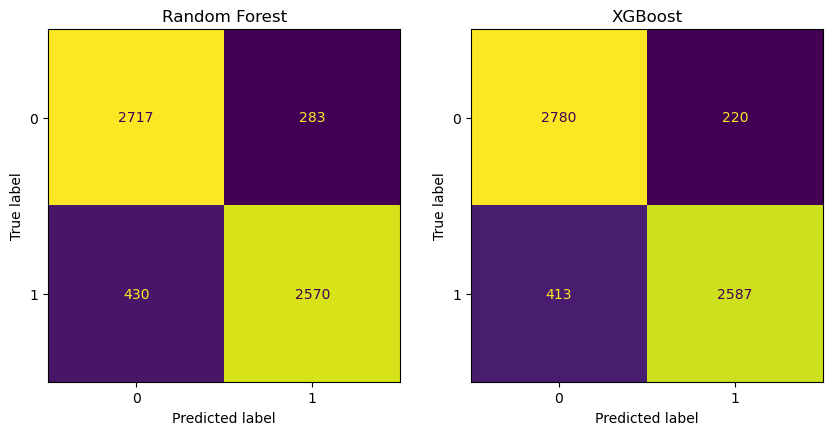

In [6]:
plt.figure(figsize=(10,10))
ax1 = plt.subplot(1,2,1)
ConfusionMatrixDisplay.from_predictions(df_val['label'], rfc_predict, colorbar=False, ax=ax1)
ax1.set_title('Random Forest')

ax2 = plt.subplot(1,2,2)
ConfusionMatrixDisplay.from_predictions(df_val['label'], xgb_predict, colorbar=False, ax=ax2)
ax2.set_title('XGBoost')

In [33]:
models_results(df_val['label'], [rfc_predict, xgb_predict], ['RFC', 'XGB'])

,f1,accuracy,precision,recall
RFC,0.878182,0.881167,0.900806,0.856667
XGB,0.890994,0.894500,0.921625,0.862333


In [34]:
rfc_predict = rfc.predict(df_train[selected_features])
xgb_predict = xgb.predict(df_train[selected_features])

In [35]:
models_results(df_train['label'], [rfc_predict, xgb_predict], ['RFC', 'XGB'])

,f1,accuracy,precision,recall
RFC,0.879421,0.88255,0.903491,0.8566
XGB,0.894341,0.89815,0.929087,0.8621


### Threshold tuning

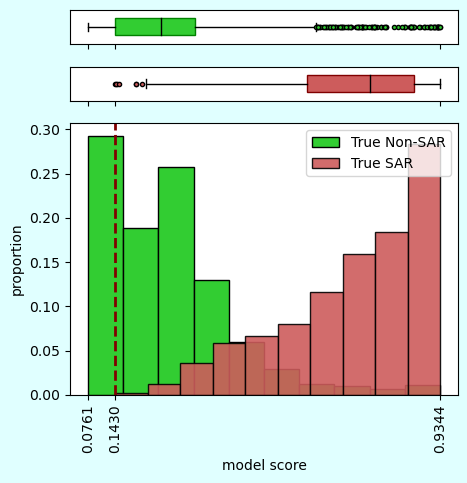

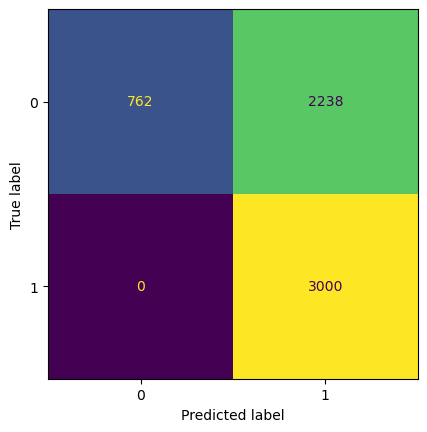

In [10]:
get_results(df_val['label'], xgb.predict_proba(df_val[selected_features])[:,1], recall=1)

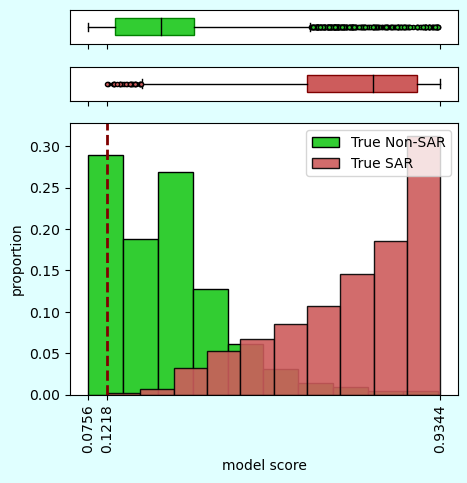

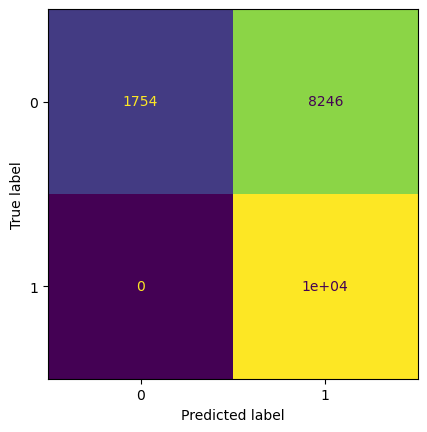

In [11]:
get_results(df_train['label'], xgb.predict_proba(df_train[selected_features])[:,1], 1)

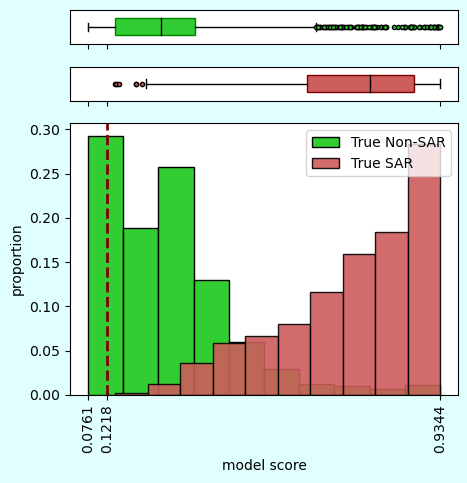

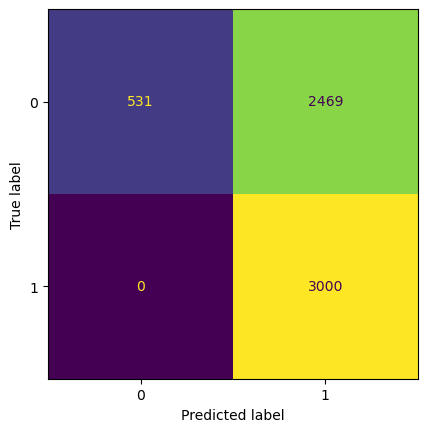

In [12]:
get_results(df_val['label'], xgb.predict_proba(df_val[selected_features])[:,1], threshold=0.1218)

### Conclusion
Threshold = 0.1218

### Results Analysis
1. Score vs variations

In [31]:
df_val['xgb_score'] = xgb.predict_proba(df_val[selected_features])[:,1]
df_val['score_bucket'] = pd.cut(df_val['xgb_score'], bins=np.arange(0.1, 1.1, 0.1), labels=[f"{i:.1f}-{i+0.1:.1f}" for i in np.arange(0.1, 1, 0.1)])

In [38]:
# score vs variations
table = pd.pivot_table(df_val[df_val['label']==1], values='name1', index='variations', columns='score_bucket', aggfunc='count')

In [40]:
table.to_csv('output/xgb_score_vs_variations_val.csv')

2. Score vs length

In [50]:
df_val['name1_length'] = df_val['name1'].str.len()
df_val['name1_length_bucket'] = pd.cut(df_val['name1_length'], bins=np.arange(0, 71, 10), labels=[f"{i+1:d}-{i+10:d}" for i in np.arange(0, 70, 10)])

In [51]:
# score vs length
table = pd.pivot_table(df_val[df_val['label']==1], values='name1', index='name1_length_bucket', columns='score_bucket', aggfunc='count')

In [52]:
table.to_csv('output/xgb_length_vs_variations_val.csv')

### Save model

In [7]:
from name_matcher import NameMatcher

In [8]:
model = xgb
selected_features = ['soundex', 'jaccard_2', 'overlap_2', 'bag', 'levenshtein', 'dlevenshtein', 'jaro_winkler',\
                   'smith_waterman', 'editex', 'lcsseq', 'bz2ncd']
name_matcher = NameMatcher(model, selected_features, 0.1218)

In [9]:
import pickle
with open('xgb_name_matcher.pkl', 'wb') as f:
    pickle.dump(name_matcher, f)